In [1]:
import data_reader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

data_path = 'C:/Users/Arkady/Google Drive/data/beyond_the_reach'

# Extract k-values

In [2]:
dr = data_reader.DataReader()
choices, dynamics = dr.read_data(data_path)

In [2]:
choices = pd.read_csv(os.path.join(data_path, 'choices_processed.txt'), sep=',')
# choices = choices.set_index(['subj_id', 'task', 'trial_no'])

In [3]:
choices.columns

Index(['subj_id', 'task', 'trial_no', 'order', 'is_staircase', 'ss_delay',
       'ss_amount', 'll_delay', 'll_amount', 'option_chosen', 'trial_time',
       'first_backwards', 'max_d', 'idx_max_d', 'RT', 'ss_chosen', 'choice',
       'chosen_amount', 'chosen_delay', 'amount_ratio', 'amount_diff',
       'amount_increase', 'LL_advantage', 'Lambda', 'max_d_z'],
      dtype='object')

In [11]:
print(choices[choices.task=='walking'].describe())
print(choices[choices.task=='mouse'].describe())

           subj_id     trial_no  ss_delay    ss_amount     ll_delay  \
count  3243.000000  3243.000000    3243.0  3243.000000  3243.000000   
mean   5549.159420    24.000000       0.0  2500.801727   184.978723   
std    2576.567563    13.566752       0.0  2192.446648   295.322938   
min    1095.000000     1.000000       0.0   100.000000     7.000000   
25%    3720.000000    12.000000       0.0   800.000000    20.000000   
50%    5813.000000    24.000000       0.0  1900.000000    80.000000   
75%    7500.000000    36.000000       0.0  4000.000000   183.000000   
max    9970.000000    47.000000       0.0  8000.000000  1095.000000   

         ll_amount   trial_time  first_backwards       max_d    idx_max_d  \
count  3243.000000  3243.000000      1720.000000  472.000000  3243.000000   
mean   3840.425532     7.345082       177.754651    0.456985    17.542707   
std    2491.872675     1.695688        38.197357    0.204782    12.280834   
min    1600.000000     3.964622         0.000000   -

In [4]:
def get_indifference_point_staircase(choices, delay):
    if len(choices[~choices.ss_chosen])==0:
        ip = 0
    elif len(choices[choices.ss_chosen])==0:
         ip = 1
    else:
        ip = (choices[choices.ss_chosen].amount_ratio.min()
                + choices[~choices.ss_chosen].amount_ratio.max())/2
    return ip

def get_indifference_points(choices_sc):
    indiff_points = (choices_sc.groupby(['subj_id', 'task', 'll_delay'])
                     .apply(lambda c: get_indifference_point_staircase(c, c.iloc[0].ll_delay))
                     .rename('indiff_point'))
    return indiff_points

def get_k(indiff_points, log_delay=False):
    '''
    Many "raw" k-values are close to 1, and to emphasize the differences between those, we
    might (or might not?) want to log-scale the delays before calculating k-values
    '''
    delays = indiff_points.ll_delay.unique()
    if log_delay:
        delays = np.log(delays)
    delays = delays/max(delays)
    values = indiff_points.indiff_point.values
    
    k = 1 - ((delays[1:] - delays[:-1]) * (values[:-1] + values[1:]) / 2).sum()

    return k

def get_k_values(choices):
    ip = get_indifference_points(choices[choices.is_staircase]).reset_index()

    k_values = ip.groupby(['subj_id', 'task']).apply(lambda x: get_k(x, log_delay=False)).rename('k-value').unstack().reset_index()
#     k_values_log = ip.groupby(['subj_id', 'task']).apply(lambda x: get_k(x, log_delay=True)).rename('k-value')
    
    k_values['k_diff'] = k_values.mouse - k_values.walking
    k_values['k_mean'] = (k_values.mouse + k_values.walking)/2
   
    return k_values, ip

def save_k_values(k_values):
    k_values_long = pd.melt(k_values, id_vars=['subj_id'], value_vars=['mouse', 'walking'], value_name='k')
    k_values_long = k_values_long.join(choices.groupby('subj_id').order.first(), on='subj_id')
    k_values_long['task_order'] = 1
    k_values_long.loc[(((k_values_long.task=='mouse') & (k_values_long.order=='wm')) | 
                  ((k_values_long.task=='walking') & (k_values_long.order=='mw'))), ['task_order']] = 2
    k_values_long = k_values_long.drop(['order'], axis=1)
    k_values_long = k_values_long.rename(columns={'task_order':'order'})

    k_values_long.to_csv(os.path.join(data_path, 'k-values.csv'), sep='\t', index=False)

# Exclusion based on k-values

We exclude subjects who discounted too much or too little in *both* tasks

In [8]:
k_values, ip = get_k_values(choices)
extreme_k = k_values.loc[((k_values.mouse>0.98)&(k_values.walking>0.98)) | 
                         ((k_values.mouse<0.02)&(k_values.walking<0.02)), 'subj_id']

print(len(extreme_k))
print(extreme_k.values)

14
[1095 1122 1282 1971 3846 4232 4679 5389 5397 5571 7095 7958 8767 9790]


In [16]:
choices = choices[~choices.subj_id.isin(extreme_k)]
k_values, ip = get_k_values(choices)
save_k_values(k_values)

# Basic k-value analysis

0.01384781029472809


Ttest_1sampResult(statistic=0.7157493146847379, pvalue=0.4772298643212558)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


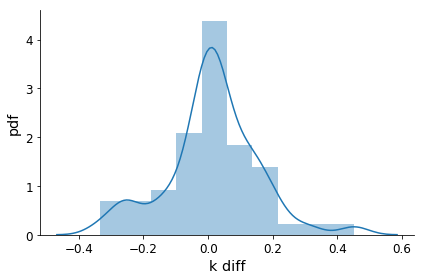

In [17]:
g = sns.distplot(k_values.k_diff, bins=10)
g.axes.set_xlabel('k diff')
g.axes.set_ylabel('pdf')
print(k_values.k_diff.mean())

from scipy.stats import ttest_1samp

ttest_1samp(k_values.k_diff, popmean=0)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


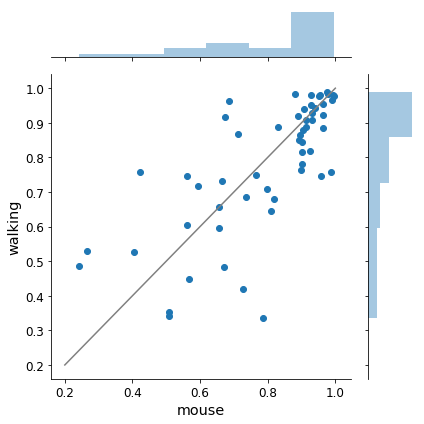

In [18]:
g = sns.jointplot(data=k_values, x='mouse', y='walking')
x = np.linspace(0.2, 1)
g.ax_joint.plot(x, x, color='grey')

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


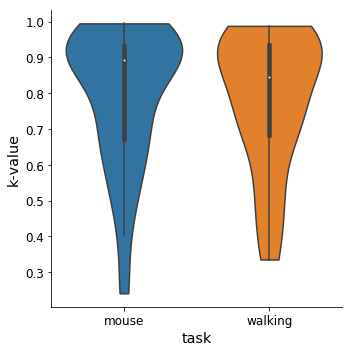

In [21]:
# sns.catplot(data=k_values.loc[:,['mouse', 'walking']].stack().rename('k-value').reset_index(), 
#             x='task', y='k-value', kind='violin')

ax = sns.catplot(data=k_values.loc[:,['mouse', 'walking']].stack().rename('k-value').reset_index().rename({'level_1': 'task'}, axis='columns'), 
                 x='task', y='k-value', 
                 kind='violin', cut=0)
# ax = sns.stripplot(data=k_values.loc[:,['mouse', 'walking']].stack().rename('k-value').reset_index().rename({'level_1': 'task'}, axis='columns'),
#                    x='task', y='k-value',
#                    size=4, jitter=0.05, color="gray")

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


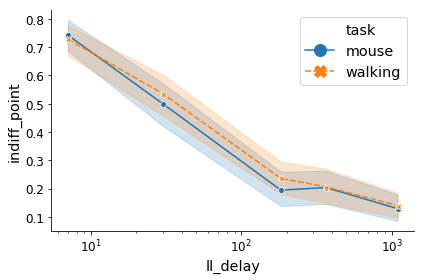

In [22]:
ax = sns.lineplot(data=ip.reset_index(), x='ll_delay', y='indiff_point', hue='task', style='task', markers=True)
sns.despine()
ax.set_xscale('log')

# Task effect might depending on individuals' k?

In [23]:
k_values_long = pd.melt(k_values, id_vars=['subj_id', 'k_quantile'], 
                        value_vars=['mouse', 'walking'], value_name='k-value')

C:\Users\Arkady\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


It seems that the effect of task might be individual-specific. E.g., people might not universally choose more SS in the walking task, but they might choose their default option more often in that task

In [24]:
sns.catplot(data=k_values_long, x='task', y='k-value', hue='k_quantile', kind='point')

ValueError: min() arg is an empty sequence

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


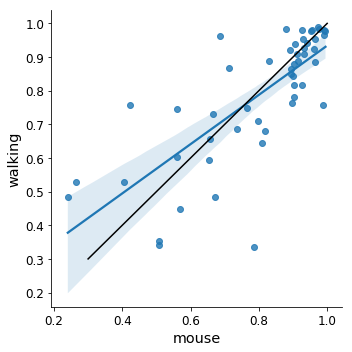

In [36]:
f = sns.lmplot(data=k_values, x='mouse', y='walking', truncate=True)
x = np.linspace(0.3, 1.0)
f.ax.plot(x, x, color='k')

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


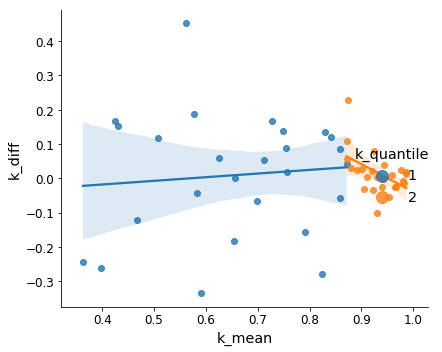

In [30]:
ax = sns.lmplot(data=k_values, x='k_mean', y='k_diff', hue='k_quantile', truncate=True)